<a href="https://colab.research.google.com/github/aafaf-arharas/ML_TPs/blob/main/01_perceptron_etud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Perceptron



Objectif : programmation d'un perceptron linéaire simple et test sur des :

    - données linéairement séparables (linear)
    - données concentriques non linéairement séparables (twocircles)
    - données en croissant non linéairement séparables (moon)

Un perceptron est une fonction du type $f(w^Tx+b)$, qui calcule une combinaison linéaire des entrées. Le vecteur $w$ est ajusté à partir d'une base d'apprentissage. Le biais $b$ peut être vu comme un poids supplémentaire, relié à une entrée égale à 1.

En classification, une fonction softmax produit la classe $softmax(w^Tx+b)$.


## Paramètres globaux

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

''' 
-------------------------------------------------------------------------
Paramètres du réseau
-------------------------------------------------------------------------
'''    
# Taille des batchs par apprentissage
batch_size = 100  

# Nombre d'itérations
num_epochs = 400

''' 
-------------------------------------------------------------------------
Paramètres du problème
-------------------------------------------------------------------------
'''   
# Nombre de classes
num_labels = 2 


# Nombre de descripteurs
num_features = 2

fichiers_train = ['/content/linear_data_train.csv','/content/twocircles_data_train.csv','/content/moon_data_train.csv']
fichiers_test = ['/content/linear_data_eval.csv','/content/twocircles_data_eval.csv','/content/moon_data_eval.csv']


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Définition d'une fonction utile pour le chargement des données

In [21]:
# Extraction des données à partir de lignes label, desc1... descn en un format compatible
def extract_data(filename):

    labels = []
    features = []

    for line in open(filename):
        row = line.split(",")
        # Les labels sont des entiers
        labels.append(int(row[0]))
        # les descripteurs sont des réels
        features.append([float(x) for x in row[1:]])

    # Conversion en des types  matrices numpy
    features_np = np.matrix(features).astype(np.float32)

    labels_np = np.array(labels).astype(dtype=np.uint8)
    #print(labels_np)

    labels_onehot = (np.arange(num_labels) == labels_np[:, None]).astype(np.float32)

    return features_np,labels_onehot


features, labels = extract_data('/content/linear_data_eval.csv')

print(labels)


[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 

Définition de la fonction d'affichage graphique des résultats (frontière de séparation et classes)

In [22]:
def plotResults(ax,X,Y,model,titre):
    # rectangle de tracé
    mins = np.amin(X,0); 
    mins = mins - 0.1*np.abs(mins);
    maxs = np.amax(X,0); 
    maxs = maxs + 0.1*maxs;

    ## Génération d'une grille
    xs,ys = np.meshgrid(np.linspace(mins[0,0],maxs[0,0],300),np.linspace(mins[0,1], maxs[0,1], 300));

    # Modèle sur la grille
    Z = np.argmax(model.predict(np.c_[xs.flatten(), ys.flatten()]), axis=-1)
    Z=Z.reshape(xs.shape[0],xs.shape[1])
    
    # conversion one shot vecteur
    labelY = np.matrix(Y[:, 0]+2*Y[:, 1])
    labelY = labelY.reshape(np.array(X[:, 0]).shape)

    ax.contourf(xs, ys, Z, cmap=plt.cm.magma,alpha=.5)
    ax.scatter(np.array(X[:, 0]),np.array(X[:, 1]),c= np.array(labelY),s=20,cmap=colors.ListedColormap(['red', 'green']))
    ax.set_title(titre)
    plt.tight_layout()


In [23]:
# Taille des batchs par apprentissage
batch_size = 100  


# Nombre d'itérations
num_epochs = 1000

# learning rate
lr = 0.01

Définition du modèle $y=softmax(w^Tx+b)$

In [25]:
# Définition du modèle 
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(Dense(2, activation="softmax" ,input_shape =(2,2)))

Optimisation et prédiction

In [32]:
# Fonction de perte et procédure d'optimisation : entropue croisée binaire et Adam
model.compile(loss="binary_crossentropy",optimizer="Adam",metrics=['accuracy'])
model.summary()   


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 2, 2)              6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


Entraînement et affichage des résultats

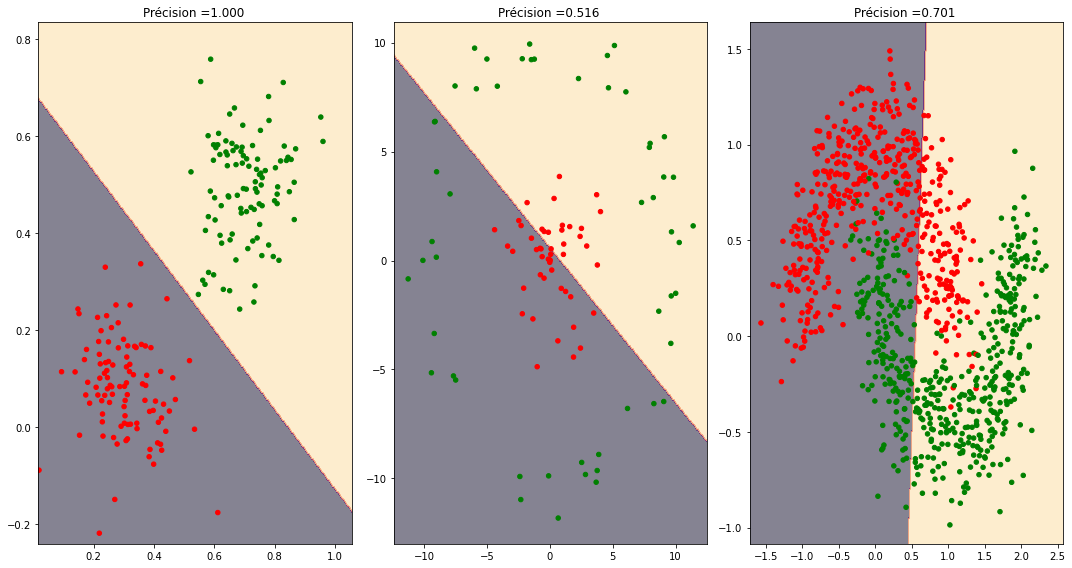

In [39]:
fig,axs = plt.subplots(1, 3,figsize=(15,8))
for i,name_train,name_test in zip ([0,1,2],fichiers_train,fichiers_test):
    train_data,train_labels = extract_data(name_train)
    test_data, test_labels = extract_data(name_test)
    train_size,num_features = train_data.shape

    # Entraînement
    hist=model.fit(train_data, train_labels, epochs=num_epochs, batch_size=batch_size,verbose=0)
    titre= "Précision ={0:5.3f} ".format(hist.history.get('accuracy')[-1])
    plotResults(axs[i],test_data, test_labels, model, titre)
            